# Topology
This example reproduces the topology constraint.

In [1]:
from quadcoil import quadcoil
from quadcoil.objective import K_theta, Phi_with_net_current, K2, K

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready
import time

In [3]:
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.geo import SurfaceRZFourier 
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

## Loading data

In [4]:
# The example is li383.
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
jax.config.update('jax_enable_x64', True)

/home/lankef/code/simsopt/src/simsopt/_core/optimizable.py:1630: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, "rt") as fp:


## Running NESCOIL for comparison

In [6]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running nescoil, with auto-generated '\
      'winding surface.')
nescoil_out_dict, nescoil_qp, nescoil_phi_mn, _ = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    objective_weight=None,
    objective_unit=None,
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running nescoil, with auto-generated winding surface.


## Running QUADCOIL, constraining the coils to be purely poloidal


In [8]:
if net_poloidal_current_amperes > 0:
    K_theta_sign = '>='
else:
    K_theta_sign = '<='
print('K_theta constraint sign: ' + K_theta_sign)

K_theta constraint sign: >=


In [9]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running quadcoil, with auto-generated '\
      'winding surface and K_theta constraint.')
out_dict, qp, phi_mn, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    # Set the constraint to K_theta
    constraint_name=('K_theta',),
    constraint_type=('>=',),
    constraint_value=(0.,),
    constraint_unit=(None,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K'),
    maxiter_inner=1500,
    maxiter_outer=10,
    ftol_inner=0,
    xtol_inner=0,
)

Running quadcoil, with auto-generated winding surface and K_theta constraint.


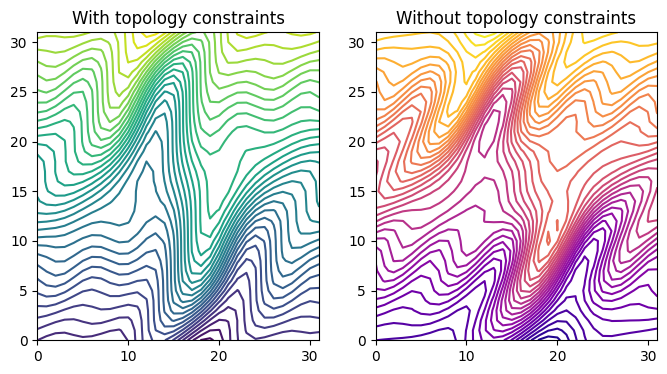

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('With topology constraints')
plt.contour(Phi_with_net_current(qp, phi_mn), levels=40)
plt.subplot(1,2,2)
plt.title('Without topology constraints')
plt.contour(Phi_with_net_current(qp, nescoil_phi_mn), levels=40, cmap='plasma')

In [11]:
print('f_B with K_theta constraints:', out_dict['f_B']['value'])
print('f_B with no constraints     :', nescoil_out_dict['f_B']['value'])
print('K_theta without constraints :', jnp.min(K_theta(qp, nescoil_phi_mn)))
print('K_theta with constraints    :', jnp.min(K_theta(qp, phi_mn)))

f_B with K_theta constraints: 0.06338841775107304
f_B with no constraints     : 0.03728631748563494
K_theta without constraints : -18105359.406912915
K_theta with constraints    : -68370.81047302112


## Output structure
The following blocks look at the structure of outputs from QUADCOIL.

In [12]:
# Printing the structure of a nested dictionary by recursion
def print_tree(d, indent=0, tab = '    '):
    for key, value in d.items():
        if isinstance(value, dict):
            print(tab * indent + '\'' + str(key) + '\'' + ': {')
            print_tree(value, indent + 1)
            print(tab * indent + '},')
        else:
            if jnp.isscalar(value):
                print(tab * indent + '\'' + str(key) + '\'' + ': ' + str(value) + ',')
            else:
                print(tab * indent + '\'' + str(key) + '\': array(dtype=' + str(value.dtype) + ', shape=' + str(value.shape) + '),')

In [13]:
print_tree(out_dict)

'f_B': {
    'grad': {
        'df_dconstraint_value': array(dtype=float64, shape=(1,)),
        'df_dnet_poloidal_current_amperes': 1.0665563051980406e-08,
        'df_dnet_toroidal_current_amperes': 3.7240900815694553e-09,
        'df_dplasma_coil_distance': 0.9833843550159864,
        'df_dplasma_dofs': array(dtype=float64, shape=(187,)),
    },
    'value': 0.06338841775107304,
},
'f_K': {
    'grad': {
        'df_dconstraint_value': array(dtype=float64, shape=(1,)),
        'df_dnet_poloidal_current_amperes': 12628782.472101763,
        'df_dnet_toroidal_current_amperes': 660739.232726985,
        'df_dplasma_coil_distance': 144504124060114.53,
        'df_dplasma_dofs': array(dtype=float64, shape=(187,)),
    },
    'value': 75040039727553.6,
},
